In [9]:
#!/usr/bin/env python3

"""
Sample script for computing/plotting GEOSldas Data Assimilation (DA) Diagnostics

This script computes and plots DA diagnostic maps from ObsFcstAna output.

Processing workflow:
1. User provides experiment information and calls ObsFcstAna_prep to:
   - Calculate/save monthly sums of Obs/Fcst/Ana and squared/products
   - Calculate mean/stdv of Obs/Fcst/Ana
2. User computes desired DA diagnostic statistics and creates plots

Usage on Discover:
    $ module load python/GEOSpyD
    $ ./Main_example.py
    
    # Background execution:
    $ nohup ./Main_example.py > out.log &

Author: Q. Liu
Last Modified: Apr., 2025
"""
import sys
sys.path.append('../../shared/python/')
import warnings; warnings.filterwarnings("ignore")
import os

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from read_GEOSldas import read_tilecoord, read_obs_param
from tile2grid             import tile2grid
from plot import plotMap
from EASEv2                 import EASEv2_ind2latlon

from postproc_ObsFcstAna    import postproc_ObsFcstAna


In [10]:

# Uncomment if to run the script in the background to see the standard output while running 
# import io
#sys.stdout = io.TextIOWrapper(open(sys.stdout.fileno(), 'wb', 0), write_through=True)
#sys.stderr = io.TextIOWrapper(open(sys.stderr.fileno(), 'wb', 0), write_through=True)

# Define time range for processing
start_time = datetime(2020,1,1)
end_time = datetime(2020,12,31)

# -------------------------------- Experiments Information -----------------------------------------
# Supports single or multiple experiments;
# multiple require identical tilecoords and numbe/order of observation species
# if the default "species" number/order don't match, need to set the *optional*
# "select_species" key to get a match, i.e. same species sequences

exp_1 = { 'expdir' : '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/',
                    'expid' : 'LS_DAv8_M36',
                    'exptag': 'DA', 
                    'domain':  'SMAP_EASEv2_M36_GLOBAL' }

#exp_2 = { 'expdir' : '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/',
#                    'expid' : 'LS_OLv8_M36',
#                    'exptag': 'OL', 
#                    'domain':  'SMAP_EASEv2_M36_GLOBAL' }


In [3]:

# Uses forecasts/analyses from first experiment in list;
# observations from experiment specified by 'obs_from' parameter
exp_list = [exp_1]
obs_from = 0 # 0 = obs is from "exp_1" etc
if obs_from >= len(exp_list):
    raise ValueError('Invalid "obs_from" value')

# Add tilecoord and obs_param information to each experiment
for exp in exp_list:
    expdir = exp['expdir']
    expid = exp['expid']
    domain = exp['domain']
    fop = expdir+expid+'/output/'+domain+'/rc_out/Y'+start_time.strftime('%Y')+'/M'+start_time.strftime('%m')+'/'+expid+'.ldas_obsparam.'+start_time.strftime('%Y%m%d')+'_0000z.txt'
    fop = expdir+expid+'/output/'+domain+'/rc_out/Y2020/M01/'+expid+'.ldas_obsparam.20200101_0000z.txt'
    obsparam = read_obs_param(fop)

    # get the species list and default to list of all species if doesn't exist 
    species_list = exp.get('species_list',[int(obsparam[i]['species']) for i in range(len(obsparam))])
    
    # reorder obsparam to match across experiments
    obsparam_new = []
    for i in range(len(obsparam)):
        if int(obsparam[i]['species']) in species_list:
               obsparam_new.append(obsparam[i])              
    obsparam = obsparam_new
    
    ftc = expdir+expid+'/output/'+ domain+'/rc_out/'+ expid+'.ldas_tilecoord.bin'
    tc = read_tilecoord(ftc)

    exp.update({'tilecoord':tc,'obsparam':obsparam})

# Top directory for monthly temporary data output;
# can match experiment's ana/ or be located elsewhere
out_path_mo = exp_list[0]['expdir']+exp_list[0]['expid']+ \
              '/output/'+exp_list[0]['domain']+'/ana/ens_avg/'

# Output directory for final diagnostic files and plots
out_path = exp_list[0]['expdir']+exp_list[0]['expid']+ \
              '/output/'+exp_list[0]['domain']+'/figures/'
make_folder(out_path)

if len(exp_list) >1 :
    stats_file  = out_path + 'tmp_stats_'+exp_list[0]['exptag']+'_obsfrom_'+ \
                  exp_list[obs_from]['exptag']+'_'+start_time.strftime('%Y%m%d')+'_'+ \
                  end_time.strftime('%Y%m%d')+'.nc4'
else:
    stats_file  = out_path + 'tmp_stats_'+exp_list[0]['exptag']+'_'+ start_time.strftime('%Y%m%d')+'_'+ \
              end_time.strftime('%Y%m%d')+'.nc4'
    
omf_stats_file  = stats_file.replace('tmp_stats','tmp_omf_stats')
omf_grouped_stats_file  = stats_file.replace('tmp_stats','tmp_omf_grouped_stats')


Reading /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/rc_out/Y2020/M01/LS_DAv8_M36.ldas_obsparam.20200101_0000z.txt
Done reading obs_param for 13 species
reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/rc_out/LS_DAv8_M36.ldas_tilecoord.bin
done reading file


In [4]:
# Initialize the preprocess object
prep = obsfcstana_prep(exp_list, start_time, end_time,obs_from=obs_from)
# Step 1: Computer and save monthly sums 
prep.save_monthly_sum(out_path_mo)

file exist, skip /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg//Y2020/M01/DA.ens_avg.ldas_ObsFcstAna.202001_stats.nc4
file exist, skip /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg//Y2020/M02/DA.ens_avg.ldas_ObsFcstAna.202002_stats.nc4
file exist, skip /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg//Y2020/M03/DA.ens_avg.ldas_ObsFcstAna.202003_stats.nc4
file exist, skip /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg//Y2020/M04/DA.ens_avg.ldas_ObsFcstAna.202004_stats.nc4
file exist, skip /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg//Y2020/M05/DA.ens_avg.ldas_ObsFcstAna.202005_stats.nc4
file exist, skip /Users/amfox/Desktop/GEOSlda

In [5]:
if not os.path.isfile(stats_file):
    # Step 2: Compute statistics from monthly sums, option to save result to file
    stats = prep.calculate_stats_fromsums(mo_path=out_path_mo, write_to_nc=True, filename=stats_file)
else:
    print('reading stats nc4 file '+stats_file)
    stats = {}
    with Dataset(stats_file,'r') as nc:
        for key, value in nc.variables.items():
            stats[key] = value[:].filled(np.nan)    

reading stats nc4 file /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/figures/tmp_stats_DA_20200101_20201231.nc4


In [6]:
if not os.path.isfile(omf_stats_file):
    # Step 3: Compute monthly mean/stdv for OmF
    omf_stats = prep.calculate_monthly_omf(mo_path=out_path_mo, write_to_nc=True, filename=omf_stats_file)
else:
    print('reading omf stats nc4 file '+omf_stats_file)
    omf_stats = {}
    with Dataset(omf_stats_file,'r') as nc:
        for key, value in nc.variables.items():
            omf_stats[key] = value[:].filled(np.nan)

reading omf stats nc4 file /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/figures/tmp_omf_stats_DA_20200101_20201231.nc4


In [9]:
sensor_groups = {k:v for k,v in {
    'SMOS':  [int(param['species'])-1 for param in obsparam if 'SMOS_fit_Tb' in param['descr']],
    'SMAP':  [int(param['species'])-1 for param in obsparam if 'SMAP_L1C_Tb' in param['descr']],
    'ASCAT': [int(param['species'])-1 for param in obsparam if 'ASCAT' in param['descr']],
    'MODIS': [int(param['species'])-1 for param in obsparam if 'MOD10C1' in param['descr'] or 'MYD10C1' in param['descr']]
}.items() if v}

if not os.path.isfile(omf_grouped_stats_file):
    # Step 4: Compute monthly mean/stdv for OmF grouped by sensor    
    omf_stats_by_sensor = prep.calculate_monthly_omf_by_sensor(sensor_groups, mo_path=out_path_mo, write_to_nc=True, filename=omf_grouped_stats_file)
else:
    print('reading omf grouped stats nc4 file '+omf_grouped_stats_file)
    omf_stats_by_sensor = {}
    with Dataset(omf_grouped_stats_file,'r') as nc:
        # Read and convert time
        time_var = nc.variables['time']
        times = num2date(time_var[:], time_var.units, calendar=time_var.calendar)
        
        # Read group names - handle masked arrays
        group_names_raw = nc.variables['group_name'][:]
        group_names = []
        for name_chars in group_names_raw:
            valid_chars = name_chars.data[~name_chars.mask] if hasattr(name_chars, 'mask') else name_chars
            group_names.append(''.join(valid_chars.astype(str)))
        
        # Initialize container
        omf_stats_by_sensor = {}
        
        # Read metrics into group-specific dictionaries
        metrics = ['N_data', 'OmF_mean', 'OmF_stdv', 'OmF_norm_mean', 'OmF_norm_stdv', 'OmA_mean', 'OmA_stdv']
        for g_idx, group in enumerate(group_names):
            omf_stats_by_sensor[group] = {
                metric: nc.variables[metric][:, :, g_idx].filled(np.nan)
                for metric in metrics
            }
        
        # Add time array
        omf_stats_by_sensor['time'] = times

reading omf grouped stats nc4 file /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/figures/tmp_omf_grouped_stats_DA_20200101_20201231.nc4


In [12]:
print(omf_stats_by_sensor['SMAP']['OmF_stdv'].shape)
print(omf_stats_by_sensor['time'])

print(omf_stats['OmF_stdv'].shape)

(12, 112573)
[cftime.DatetimeGregorian(2020, 1, 1, 3, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2020, 2, 1, 3, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2020, 3, 1, 3, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2020, 4, 1, 3, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2020, 5, 1, 3, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2020, 6, 1, 3, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2020, 7, 1, 3, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2020, 8, 1, 3, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2020, 9, 1, 3, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2020, 10, 1, 3, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2020, 11, 1, 3, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2020, 12, 1, 3, 0, 0, 0, has_year_zero=False)]
(12, 112573, 13)


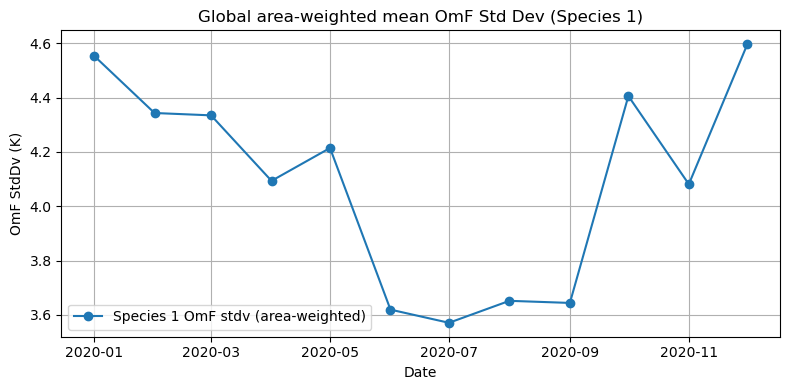

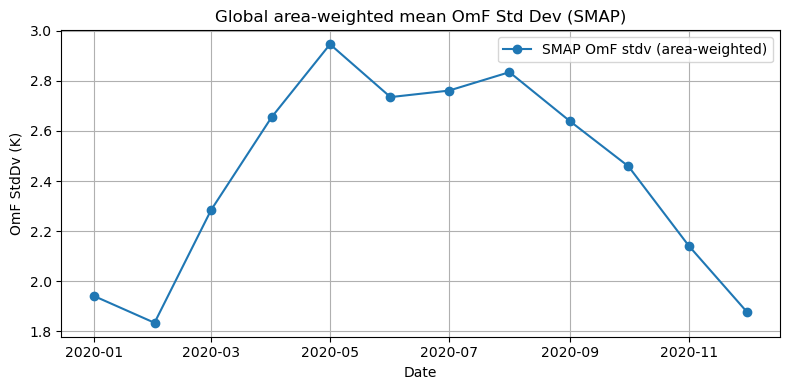

In [24]:
# Extract data
OmF_stdv = omf_stats['OmF_stdv'][:, :, 0]  # shape: (time, tile, species)
area = tc['area']                          # shape: (tile,)
time = omf_stats['time']                   # list of datetime.datetime
time = num2date(time, 'days since 1900-01-01 00:00:00', calendar='standard')


time = [datetime(t.year, t.month, t.day, t.hour, t.minute, t.second) for t in time]

# Compute area-weighted mean over time
wmean_series = []
for i in range(OmF_stdv.shape[0]):
    data = OmF_stdv[i, :]
    weights = np.where(~np.isnan(data), area, 0.0)
    wmean = np.nansum(data * area) / np.nansum(weights)
    wmean_series.append(wmean)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(time, wmean_series, marker='o', label='Species 1 OmF stdv (area-weighted)')
plt.ylabel('OmF StdDv (K)')
plt.xlabel('Date')
plt.title('Global area-weighted mean OmF Std Dev (Species 1)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


# Extract data
OmF_stdv = omf_stats_by_sensor['SMAP']['OmF_stdv']  # shape: (time, tile)
area = tc['area']                                    # shape: (tile,)
time = omf_stats_by_sensor['time']                   # list of datetime.datetime

time = [datetime(t.year, t.month, t.day, t.hour, t.minute, t.second) for t in time]

# Compute area-weighted mean over time
wmean_series = []
for i in range(OmF_stdv.shape[0]):
    data = OmF_stdv[i, :]
    weights = np.where(~np.isnan(data), area, 0.0)
    wmean = np.nansum(data * area) / np.nansum(weights)
    wmean_series.append(wmean)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(time, wmean_series, marker='o', label='SMAP OmF stdv (area-weighted)')
plt.ylabel('OmF StdDv (K)')
plt.xlabel('Date')
plt.title('Global area-weighted mean OmF Std Dev (SMAP)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
def process_obsparam(obsparam):
    # Create groups based on instrument types
    groups = {
        'SMOS': [],    # SMOS Tb observations
        'SMAP': [],    # SMAP Tb observations  
        'ASCAT': [],   # ASCAT soil moisture
        'MODIS': []    # MODIS snow cover
    }
    
    # Map each species to its group based on description
    for param in obsparam:
        if 'SMOS_fit_Tb' in param['descr']:
            groups['SMOS'].append(int(param['species']))
        elif 'SMAP_L1C_Tb' in param['descr']:
            groups['SMAP'].append(int(param['species']))
        elif 'ASCAT' in param['descr']:
            groups['ASCAT'].append(int(param['species']))
        elif 'MOD10C1' in param['descr'] or 'MYD10C1' in param['descr']:
            groups['MODIS'].append(int(param['species']))
    
    # Remove empty groups
    return {k:v for k,v in groups.items() if v}

sensor_groups = process_obsparam(obsparam)
print("Grouped species by sensor:")
for sensor, species_list in sensor_groups.items():
    print(f"{sensor}: Species {species_list}")


In [ ]:
STOP


#  =========================================================================
#  Prepocess raw ObsFcstAna output data into monthly sums for simpler and faster postprocessing;
#  computes mean, vairance from monthly sums that can be used to compute DA diagnostics directly

if not os.path.isfile(stats_file):
    # Initialize the preprocess object
    prep = obsfcstana_prep(exp_list, start_time, end_time,obs_from=obs_from)
    # Step 1: Computer and save monthly sums 
    prep.save_monthly_sum(out_path_mo)
    # Step 2: Compute statistics from monthly sums, option to save result to file
    stats = prep.calculate_stats_fromsums(mo_path=out_path_mo, write_to_nc=True, filename=stats_file)
    # Step 3: Compute monthly mean/stdv for OmF
    omf_stats = prep.calculate_monthly_omf(mo_path=out_path_mo, write_to_nc=True, filename=stats_file)
else:
    print('reading stats nc4 file '+stats_file)
    stats = {}
    with Dataset(stats_file,'r') as nc:
        for key, value in nc.variables.items():
            stats[key] = value[:].filled(np.nan)
# 
#  ==========================================================================


In [ ]:

# Sample of final compuation of selected diagnostic metrics 
 
Nmin = 20

# Then computer metrics of O-F, O-A, etc. based on above computed
N_data = stats['N_data']
O_mean = stats['obs_mean']
# mean(x-y) = E[x] - E[y]   
OmF_mean = stats['obs_mean'] - stats['fcst_mean']
print("omf_mean mean: ", np.nanmean(OmF_mean))
OmA_mean = stats['obs_mean'] - stats['ana_mean']
# var(x-y) = var(x) + var(y) - 2cov(x,y)
# cov(x,y) = E[xy] - E[x]E[y]
OmF_stdv  = np.sqrt(stats['obs_variance'] + stats['fcst_variance'] - \
                       2 * (stats['oxf_mean'] - stats['obs_mean']*stats['fcst_mean']))
                    
OmA_stdv  = np.sqrt(stats['obs_variance'] + stats['ana_variance'] - \
                       2 * (stats['oxa_mean'] - stats['obs_mean']*stats['ana_mean']))

 # "fcstvar" is assumed constant here for convenience. Modify if necessary
OmF_norm_mean = OmF_mean / np.sqrt(stats['obsvar_mean'] + stats['fcstvar_mean']) 
OmF_norm_stdv = np.sqrt(OmF_stdv**2 / (stats['obsvar_mean'] + stats['fcstvar_mean']) )
  
# Mask out data points with insufficent observations using the Nmin threshold
# Do NOT apply to N_data
OmF_mean[N_data < Nmin] = np.nan
OmF_stdv[N_data < Nmin] = np.nan
OmF_norm_mean[N_data < Nmin] = np.nan
OmF_norm_stdv[N_data < Nmin] = np.nan
OmA_mean[N_data < Nmin] = np.nan
OmA_stdv[N_data < Nmin] = np.nan

# Combine metrics of individual species using weighted averaging
#OmF_mean = np.nansum(OmF_mean*N_data, axis=1)/np.nansum(N_data,axis=1)
#OmF_stdv = np.nansum(OmF_stdv*N_data,axis=1)/np.nansum(N_data,axis=1)
#OmF_norm_mean = np.nansum(OmF_norm_mean*N_data, axis=1)/np.nansum(N_data,axis=1)
#OmF_norm_stdv = np.nansum(OmF_norm_stdv*N_data,axis=1)/np.nansum(N_data,axis=1)
#OmA_mean = np.nansum(OmA_mean*N_data, axis=1)/np.nansum(N_data,axis=1)
#OmA_stdv = np.nansum(OmA_stdv*N_data,axis=1)/np.nansum(N_data,axis=1)
#Nobs_data = np.nansum(N_data, axis=1)

In [ ]:
print(stats['fcstvar_mean'])

In [ ]:
print(omf_stats['N_data'].shape)
print(N_data.shape)

print("sum N_data: ", np.nansum(omf_stats['N_data']))
print("sum N_data from stats: ", np.nansum(N_data))

print("mean of N_data: ", np.nanmean(omf_stats['N_data']))
print("mean of N_data from stats: ", np.nanmean(N_data))

N_data_annual_sum = np.nansum(omf_stats['N_data'], axis=0)
N_data_annual_count = np.sum(~np.isnan(omf_stats['N_data']), axis=0)
N_data_annual_mean = N_data_annual_sum / N_data_annual_count


print("mean of computed annual mean:", np.nanmean(N_data_annual_mean))
print("mean of N_data from stats:", np.nanmean(N_data))

print("Mean of total monthly N_data:", np.nanmean(np.nansum(omf_stats['OmF_stdv'], axis=0)))
print("Mean of annual N_data:", np.nanmean(OmF_stdv))  


In [ ]:
# Calculate and print the mean for each species from OmF_stdv
species_means = np.nanmean(OmF_stdv, axis=(0))
for idx, mean in enumerate(species_means, start=1):
    print(f"Species {idx}: Mean OmF_stdv = {mean}")

import numpy as np
import matplotlib.pyplot as plt

to_plot = omf_stats['OmF_stdv']  # shape (12, 112573, 13)

# Compute monthly spatial mean for each species
monthly_means = np.nanmean(to_plot, axis=1)  # shape (12, 13)

months = np.arange(1, 13)

for s in range(13):
    plt.figure(figsize=(10, 6))
    plt.plot(months, monthly_means[:, s], label=f"Species {s+1}")

    plt.xlabel("Month")
    plt.ylabel("Spatial mean N_data")
    plt.title("Monthly spatial mean N_data by species")
    plt.legend(loc="upper right", fontsize="small", ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:

# Plotting
expid = exp_list[0]['exptag']

fig, axes = plt.subplots(2,2, figsize=(18,10))
plt.rcParams.update({'font.size':14})

for i in np.arange(2):
    for j in np.arange(2):
        units = '[k]'
        if i == 0 and j == 0:
            tile_data = Nobs_data
            # crange is [cmin, cmax]
            crange =[0, np.ceil((end_time-start_time).days/150)*300]
            colormap = plt.get_cmap('jet',20)
            title_txt = expid + ' Tb Nobs '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
            units = '[-]'
        if i == 0 and j ==1:
            tile_data = OmF_mean
            crange =[-3, 3]
            colormap = plt.get_cmap('bwr', 15) 
            title_txt = expid + ' Tb O-F mean '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 0:
            tile_data = OmF_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' Tb O-F stdv '+ start_time.strftime('%Y%m')+'_'+end_time.strftime('%Y%m')
        if i == 1 and j == 1:
            tile_data = OmF_norm_stdv
            crange =[0, 15]
            colormap = plt.get_cmap ('jet',15)
            title_txt = expid + ' Tb normalized O-F stdv '+ start_time.strftime('%Y%m%d')+'_'+end_time.strftime('%Y%m%d')

        colormap.set_bad(color='0.9') # light grey, 0-black, 1-white

        # Regrid 1d tile_data to 2d grid_data for map plots
        if '_M09_' in domain: # special case  
            grid_data_M09 = np.zeros((1624, 3856)) + np.nan  
            grid_data_M09[tc['j_indg'],tc['i_indg']] = tile_data
            
            # Reshape the data into 4x4 blocks
            reshaped = grid_data_M09.reshape(1624//4, 4, 3856//4, 4)

            # Combine each 4x4 M09 block into a M36 grid
            #if i==0 and j==0:
            #   grid_data = np.sum(reshaped,axis=(1, 3)) 
            #else:
            #   grid_data = np.nanmean(reshaped,axis=(1, 3))

            grid_data = grid_data_M09[1::4, 2::4]

            # NOT area weighted 
            wmean = np.nanmean(grid_data)
            wabsmean = np.nanmean(np.abs(grid_data))
            if 'normalized' in title_txt:
                wabsmean = np.nanmean(np.abs(grid_data-1.))
                
            lat_M36, lon_M36 = easev2_ind2latlon(np.arange(406), np.arange(964),'M36')
            lon_2d,lat_2d = np.meshgrid(lon_M36,lat_M36)
        else:
            grid_data, uy,ux = array2grid(tile_data, lat = tc['com_lat'], lon = tc['com_lon'])
            lon_2d,lat_2d = np.meshgrid(ux, uy)

            # Aear weighted mean and mean(abs)
            wmean = np.nansum(tile_data * tc['area'])/np.nansum(~np.isnan(tile_data)*tc['area'])
            wabsmean = np.nansum(np.abs(tile_data) * tc['area'])/np.nansum(~np.isnan(tile_data)*tc['area'])
            if 'normalized' in title_txt:
                wabsmean = np.nansum(np.abs(tile_data-1.)*tc['area'])/np.nansum(~np.isnan(tile_data)*tc['area'])
                
        if 'normalized' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs(nstdv-1))=%.3f" % (wmean, wabsmean)+' '+units
        elif 'mean' in title_txt:
            title_txt = title_txt + '\n' + "avg=%.3f, avg(abs)=%.3f" % (wmean, wabsmean)+' '+units
        else:
            title_txt = title_txt + '\n' + "avg=%.2f" % (wmean) +' '+units                
     
        if 'normalized' in title_txt:
            grid_data = np.log10(grid_data)
            crange = [-0.6, 0.45]
            
        mm, cs = plotMap(grid_data, ax =axes[i,j], lat=lat_2d, lon=lon_2d, cRange=crange, \
                    title=title_txt, cmap=colormap, bounding=[-60, 80, -180,180])            

plt.tight_layout()
# Save figure to file
fig.savefig(out_path+'Map_OmF_'+ expid +'_'+start_time.strftime('%Y%m')+'_'+\
                    end_time.strftime('%Y%m')+'.png')
plt.show()
plt.close(fig)

